# GANs and BNNs

## Generative Adversarial Networks Example

In [1]:
#Required Libraries
import numpy as np                     #for numerical computation
import matplotlib.pyplot as plt        #for data visualization
import tensorflow as tf                #for deep learning implementation
from tensorflow import keras           #for providing a Python interface for ANNs

In [2]:
#Load mnist dataset from Internet
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

In [3]:
#path = 'C:/Users/Desktop/ML/DataScience/S32/mnist.zip'

In [4]:
#Load mnist dataset from file
#from tensorflow.keras.datasets import mnist
#(X_train, y_train), (X_test, y_test) = mnist.load_data(path)

In [3]:
X_train.shape

(60000, 28, 28)

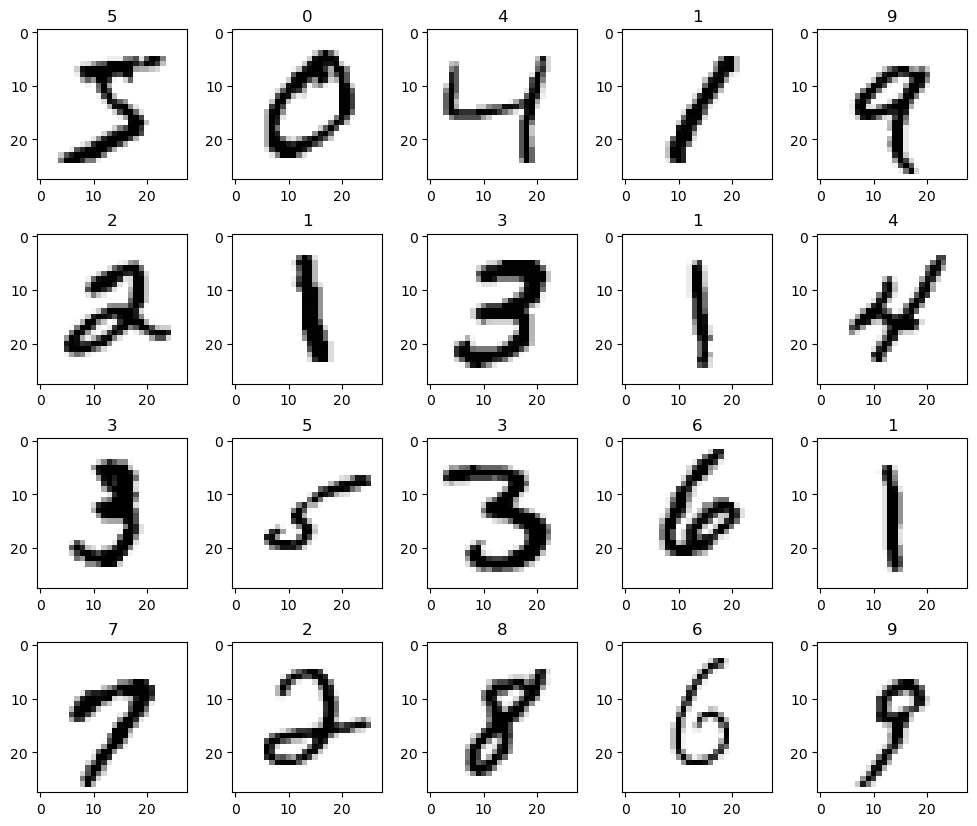

In [4]:
#Plot the First 20 Images from X_train
plot = plt.figure(figsize = (12, 10))
plot.subplots_adjust(hspace = 0.3, wspace = 0.3)
for i in range(20):
    a = plot.add_subplot(4, 5, i + 1)
    a.imshow(X_train[i], cmap = plt.cm.binary)
    a.title.set_text(y_train[i])

In [5]:
#Scale feature dataset to range 0-1
X_train_scaled = X_train / 255

In [6]:
#Reshape Dataset
X_train_scaled = X_train_scaled.reshape(-1, 28 * 28)

In [7]:
X_train_scaled.shape

(60000, 784)

In [8]:
X_train_scaled.astype('float32')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
X_train_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
#Define the Model Architecture
#Generator
z_size = 100
model_generator = keras.models.Sequential()
weight_initializer = keras.initializers.HeNormal()
model_generator.add(keras.layers.Dense(128,
                                       input_dim = z_size,
                                       activation = 'relu', 
                                       kernel_initializer = weight_initializer))

model_generator.add(keras.layers.Dense(28 * 28,
                                       activation = "sigmoid", 
                                       kernel_initializer = weight_initializer))

#Discriminator
model_discriminator = keras.models.Sequential()
weight_initializer = keras.initializers.HeNormal()
model_discriminator.add(keras.layers.Dense(128, 
                                       input_dim = 28 * 28, 
                                       activation = 'relu', 
                                       kernel_initializer = weight_initializer))
model_discriminator.add(keras.layers.Dense(1, 
                                       activation = "sigmoid",
                                       kernel_initializer = weight_initializer))


#GANs model
model_gans = keras.models.Sequential([model_generator, model_discriminator])
model_gans.summary()

D:\anaconda\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       114,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       100,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,673 (838.57 KB)

 Trainable params: 214,673 (838.57 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#Compile the model
model_discriminator.compile(loss = "binary_crossentropy", optimizer = "adam")
model_discriminator.trainable = False
model_gans.compile(loss = "binary_crossentropy", optimizer = "adam")

In [12]:
#Reading data in batch
def read_batch(batch_size, X):
    sample_size = X.shape[0]
    indices = list(range(sample_size))
    np.random.shuffle(indices)           #read data at random
    for i in range(0, sample_size, batch_size):
        batch_indices = tf.constant(indices[i : min(i + batch_size, sample_size)])
        yield tf.gather(X, batch_indices)
        #use yield to iterate over a sequence, but not to store the entire sequence in memory

In [13]:
#Batch size
batch_size = 32

In [14]:
#Train GANs
def train_gans(model = model_gans, data = X_train_scaled, batch_size = batch_size, num_epochs = 10):
    generator, discriminator = model.layers
    
    for epoch in range(num_epochs):
        for X_batch in read_batch(batch_size, data):
            
            #Change data type to float32
            X_batch = tf.cast(X_batch, tf.float32)
            
            #Train the discriminator
            z = tf.random.normal(shape = [batch_size, z_size])
            generated_images = generator(z)
            X_fake_real = tf.concat([generated_images, X_batch], axis = 0)
            #Set response to 0 for fake images and 1 for real images
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) 
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_real, y1)
            
            #Train the generator
            z = tf.random.normal(shape = [batch_size, z_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            model.train_on_batch(z, y2)

In [15]:
#Create random input
z = tf.random.normal(shape = [20, z_size])

In [16]:
#Output w/o training
images = model_generator.predict(z)
images = np.round(images * 255, decimals = 0)
images = images.astype('uint8')
images = images.reshape(-1, 28, 28)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


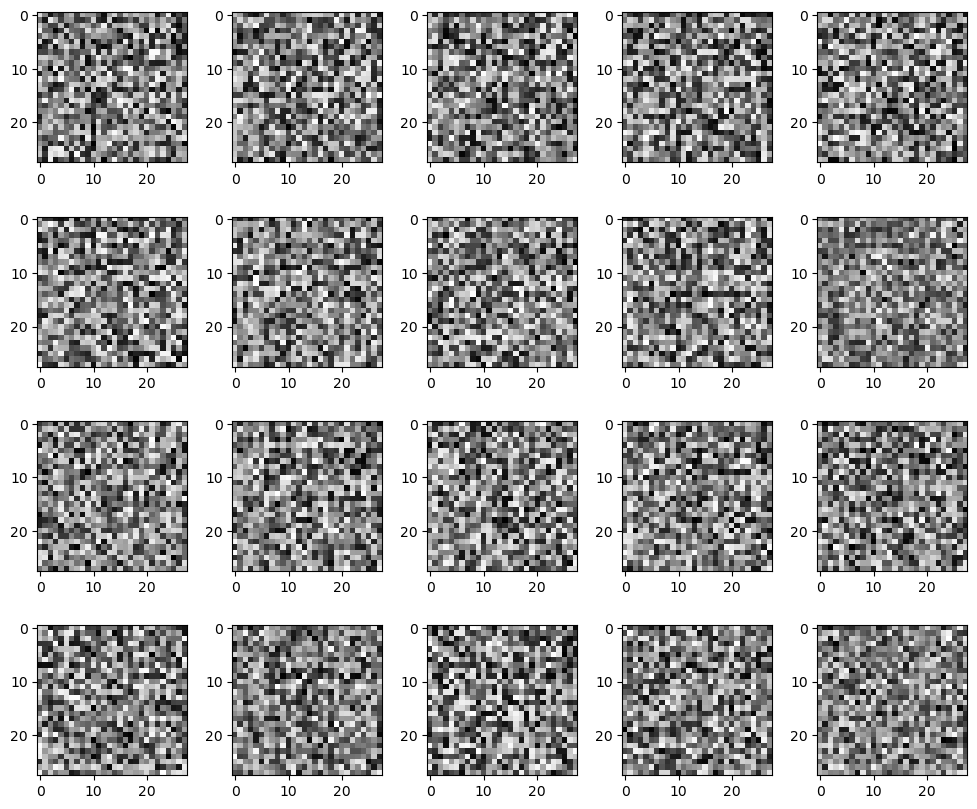

In [17]:
#Plot the generated 20 Images
plot = plt.figure(figsize = (12, 10))
plot.subplots_adjust(hspace = 0.3, wspace = 0.3)
for i in range(20):
    a = plot.add_subplot(4, 5, i + 1)
    a.imshow(images[i], cmap = plt.cm.binary)

In [ ]:
#Train for 10 epochs
train_gans(model = model_gans, data = X_train_scaled, batch_size = batch_size, num_epochs = 10)

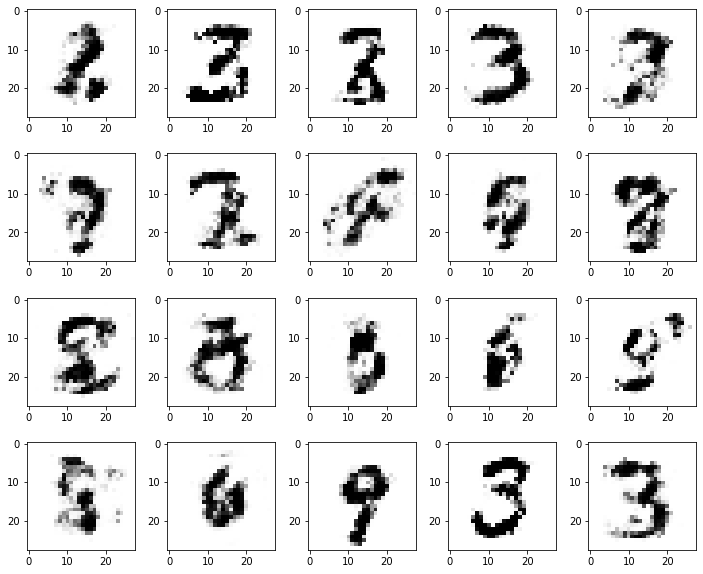

In [21]:
#Output after 10 epochs training
images = model_generator.predict(z)
images = np.round(images * 255, decimals = 0)
images = images.astype('uint8')
images = images.reshape(-1, 28, 28)

#Plot the generated 20 Images
plot = plt.figure(figsize = (12, 10))
plot.subplots_adjust(hspace = 0.3, wspace = 0.3)
for i in range(20):
    a = plot.add_subplot(4, 5, i + 1)
    a.imshow(images[i], cmap = plt.cm.binary)

In [22]:
#Train for another 10 epochs
train_gans(model = model_gans, data = X_train_scaled, batch_size = batch_size, num_epochs = 10)

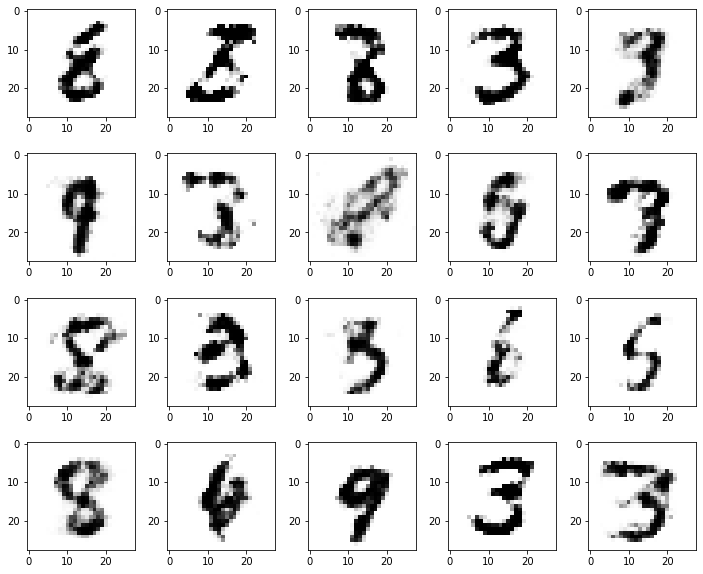

In [23]:
#Output after another 10 epochs training
images = model_generator.predict(z)
images = np.round(images * 255, decimals = 0)
images = images.astype('uint8')
images = images.reshape(-1, 28, 28)

#Plot the generated 20 Images
plot = plt.figure(figsize = (12, 10))
plot.subplots_adjust(hspace = 0.3, wspace = 0.3)
for i in range(20):
    a = plot.add_subplot(4, 5, i + 1)
    a.imshow(images[i], cmap = plt.cm.binary)

## Bayesian Neural Networks

In [ ]:
#Classic Linear Regression - Conceptual Architecture
import tensorflow as tf                

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_units, ...)
    
])

In [ ]:
#Bayesian Regression - Conceptual Architecture
#Learn known unknowns
import tensorflow as tf                
import tensorflow_probability as tfp
tfd = tfp.distributions

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_units, ...),
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(lambda t: 
                                  tfd.Normal(loc = t[..., 0],
                                             scale = tf.math.softplus(t[..., 1])))
    
])

In [ ]:
#Bayesian Regression - Conceptual Architecture
#Learn unknown unknowns
import tensorflow as tf                
import tensorflow_probability as tfp
tfd = tfp.distributions

model = tf.keras.Sequential([
    tfp.layers.DenseVariational(hidden_units, ...),
    tfp.layers.DenseVariational(1),
    tfp.layers.DistributionLambda(lambda t: 
                                  tfd.Normal(loc = t[..., 0],
                                             scale = 1))
    
])

In [ ]:
#Bayesian Regression - Conceptual Architecture
#Learn known & unknown unknowns
import tensorflow as tf                
import tensorflow_probability as tfp
tfd = tfp.distributions

model = tf.keras.Sequential([
    tfp.layers.DenseVariational(hidden_units, ...),
    tfp.layers.DenseVariational(1 + 1),
    tfp.layers.DistributionLambda(lambda t: 
                                  tfd.Normal(loc = t[..., 0],
                                             scale = tf.math.softplus(t[..., 1])))
    
])

In [ ]:
#Gaussian Process - Conceptual Architecture
import tensorflow as tf                
import tensorflow_probability as tfp
tfd = tfp.distributions

model = tf.keras.Sequential([
    tfp.layers.Dense(hidden_units, ...),
    tfp.layers.Dense(1),
    tfp.layers.VariationalGaussianProcess(num_inducing_points, kernel_provider)
    
])